In [1]:
!pip install --upgrade scikit-learn

In [2]:
import sklearn
from packaging import version

sklearn.__version__

'1.2.0'

In [3]:
from sklearn.datasets import fetch_openml

In [4]:
mnist = fetch_openml('mnist_784', as_frame=False)

/Users/aina/opt/anaconda3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


options of openml:

- fetch_* - to use available datasets
- make_* - to make your own
- load*_ - small toy datasets

sklearn.utils.Bunch -> way in which the dataset is returned (or a tuple (X,y)), contains:
- DESCR
- data
- target

In [5]:
type(mnist)

sklearn.utils._bunch.Bunch

In [6]:
X,y = mnist.data, mnist.target
print(X.shape, y.shape)

(70000, 784) (70000,)


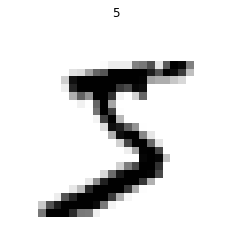

In [132]:
import matplotlib.pyplot as plt

def plot_digit(image_data, target_data=''):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    plt.title(target_data)

plot_digit(X[0], y[0])


In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# BINARY CLASSIFICATION

In [9]:
y_train_5 = (y_train == '5') #true for all instances where it is a 5 and else false
y_test_5 = (y_test == '5')

In [10]:
from sklearn.linear_model import SGDClassifier

In [11]:
sgd_cls = SGDClassifier(random_state=42)
sgd_cls.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_cls.predict([X[0]])

array([ True])

In [13]:
from sklearn.model_selection import cross_val_score

In [14]:
cross_val_score(sgd_cls, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [15]:
from sklearn.dummy import DummyClassifier

In [16]:
dummy_cls = DummyClassifier()
dummy_cls.fit(X_train, y_train_5)
cross_val_score(dummy_cls, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is
                                       # not already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_cls = clone(sgd_cls)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_cls.fit(X_train_folds, y_train_folds)
    y_pred = clone_cls.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.95035, 0.96035, and 0.9604

0.95035
0.96035
0.9604


In [18]:
from sklearn.model_selection import cross_val_predict

In [19]:
y_train_pred = cross_val_predict(sgd_cls, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
#in the confusion matrix each row is a class and each column a prediction
cm

array([[53892,   687],
       [ 1891,  3530]])

In [21]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [22]:
from sklearn.metrics import precision_score, recall_score

print(f"Precision: {precision_score(y_train_5, y_train_pred)}, \nRecall: {recall_score(y_train_5, y_train_pred)}")

Precision: 0.8370879772350012, 
Recall: 0.6511713705958311


In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [24]:
y_decision_score = sgd_cls.decision_function([X[0]])
print(y_decision_score)

[2164.22030239]


In [25]:
threshold = 0

In [26]:
y_decision_score > threshold

array([ True])

In [27]:
y_decision_scores = cross_val_predict(sgd_cls, X_train, y_train_5, cv=3, method='decision_function')

In [28]:
y_decision_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_decision_scores)

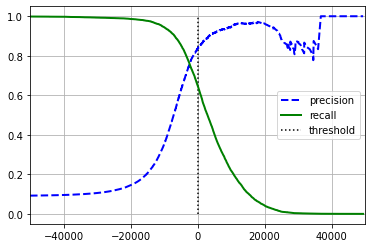

In [30]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.grid()
plt.legend(["precision", "recall", "threshold"])
plt.xlim(-50000, 50000)
[...]  # beautify the figure: axis, labels, and circles
plt.show()

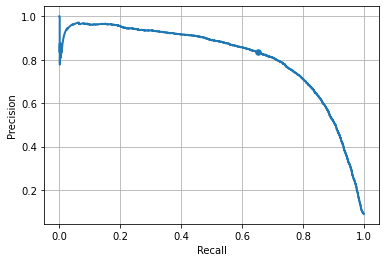

In [31]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.ylabel("Precision"); plt.xlabel("Recall")
plt.scatter(recalls[55781], precisions[55781], s=30)
plt.grid()
[...]  # beautify the figure: add labels, grid, legend, arrow, and text
plt.show()

In [32]:
import numpy as np

np.where((thresholds < 3) & (thresholds > -3))

(array([55781, 55782]),)

In [33]:
#argmax() method. This returns the first index of the maximum value, which in this case means the first True value:

idx_for_90_precision = (precisions>=0.9).argmax()
idx_for_90_precision

57109

In [34]:
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [35]:
y_train_pred_90 = (y_decision_scores >= threshold_for_90_precision)

In [36]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [37]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

In [38]:
#ROC
from sklearn.metrics import roc_curve

In [39]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_decision_scores)

In [40]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
print(tpr_90, fpr_90)

0.4799852425751706 0.005295076861063779


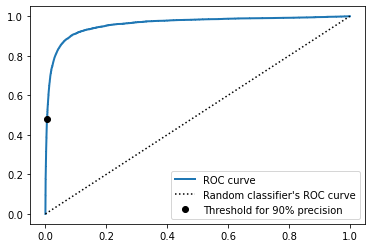

In [41]:
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.legend(['ROC curve',"Random classifier's ROC curve","Threshold for 90% precision"])
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_decision_scores)

0.9604938554008616

In [43]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

forest_cls = RandomForestClassifier(random_state=42)

In [44]:
y_probas_forest = cross_val_predict(forest_cls, X_train, y_train_5, cv=3, method='predict_proba')

In [45]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [46]:
# the second column contains the probabilities for the positive class, so that is what we will use as a surrogate for the decision_function

y_scores_forest = y_probas_forest[:,1]

In [47]:
precision_forest, recall_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

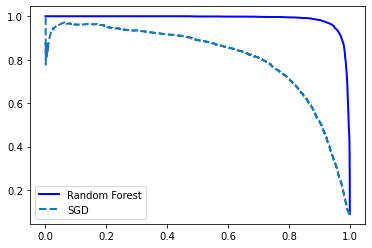

In [51]:
plt.plot(recall_forest, precision_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.legend(loc="lower left")
plt.show()

In [49]:
y_train_pred_forest = y_probas_forest[:,1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [59]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [60]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

In [63]:
from sklearn.svm import SVC

svm_cls = SVC(random_state=42)

In [64]:
svm_cls.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [68]:
some_digit = X[0]
svm_cls.predict([some_digit])

array(['5'], dtype=object)

In [73]:
some_digit_scores = svm_cls.decision_function([some_digit])
some_digit_scores.round(3)

array([[ 3.793,  0.729,  6.062,  8.298, -0.294,  9.302,  1.747,  2.774,
         7.206,  4.822]])

In [75]:
class_id = some_digit_scores.argmax()
class_id

5

In [76]:
svm_cls.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [77]:
svm_cls.classes_[class_id]

'5'

In [78]:
from sklearn.multiclass import OneVsRestClassifier

ovr_cls = OneVsRestClassifier(SVC(random_state=42))

In [79]:
ovr_cls.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [81]:
ovr_cls.predict([some_digit])

array(['5'], dtype='<U1')

In [83]:
len(ovr_cls.estimators_)

10

In [84]:
sgd_cls = SGDClassifier(random_state=42)

In [87]:
sgd_cls.fit(X_train, y_train)
sgd_cls.predict([some_digit])

array(['3'], dtype='<U1')

In [88]:
sgd_cls.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [89]:
cross_val_score(sgd_cls, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [92]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [93]:
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))

In [96]:
cross_val_score(sgd_cls, X_train_scaled, y_train, cv=3, scoring='accuracy', n_jobs=-1)

array([0.8983, 0.891 , 0.9018])

In [97]:
from sklearn.metrics import ConfusionMatrixDisplay

In [99]:
y_train_pred = cross_val_predict(sgd_cls, X_train_scaled, y_train, cv=3, n_jobs=-1)

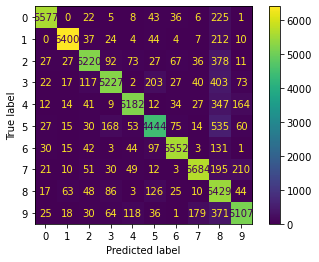

In [100]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

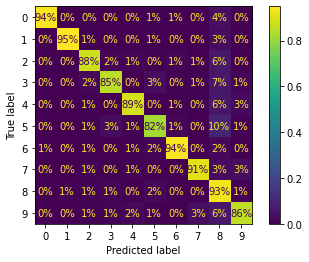

In [102]:
#normalize per each row
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, 
                                        normalize='true', values_format='.0%')
plt.show()

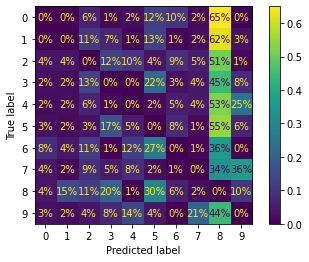

In [103]:
#display only the errors (highlight mistakes)
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, 
                                        normalize='true', values_format='.0%')

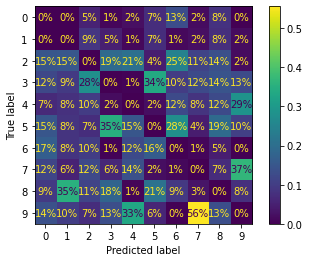

In [104]:
#normalize by the predictions (columns)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, 
                                        normalize='pred', values_format='.0%')

In [106]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

## MULTILABEL

In [109]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

In [110]:
#create a multilabel classification where the first element indicates wether it is larger than 7 and the second wether the number is odd
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [111]:
knn_cls = KNeighborsClassifier()
knn_cls.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [112]:
knn_cls.predict([some_digit])

array([[False,  True]])

In [114]:
y_train_knn_pred = cross_val_predict(knn_cls, X_train, y_multilabel, cv=3, n_jobs=-1)

In [115]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

In [116]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

In [117]:
from sklearn.multioutput import ClassifierChain

In [119]:
chain_cls = ClassifierChain(SVC(), cv=3, random_state=42)

In [120]:
chain_cls.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [121]:
chain_cls.predict([some_digit])

array([[0., 1.]])

# Multioutput Classification

In [123]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [126]:
knn_cls = KNeighborsClassifier()
knn_cls.fit(X_train_mod, y_train_mod)
clean_digit = knn_cls.predict([X_test_mod[0]])

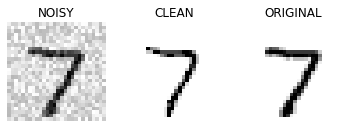

In [143]:
plt.subplot(1,3,2)
plot_digit(clean_digit, "CLEAN")
plt.subplot(1,3,1)
plot_digit(X_test_mod[0], "NOISY")
plt.subplot(1,3,3)
plot_digit(X_test[0], "ORIGINAL")

Object `plot_digit()` not found.
